# Precipitation and Station Analysis

In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
Base = automap_base()
Base.prepare(autoload_with = engine)
Base.classes.keys()

['measurement', 'station']

In [6]:
Station = Base.classes.station
Measurement = Base.classes.measurement

In [7]:
session = Session(engine)

# Exploratory Precipitation Analysis

In [8]:
# Find the most recent date in the data set.
most_recent_date = session.query(func.max(Measurement.date)).scalar()
most_recent_date

'2017-08-23'

<function matplotlib.pyplot.show(close=None, block=None)>

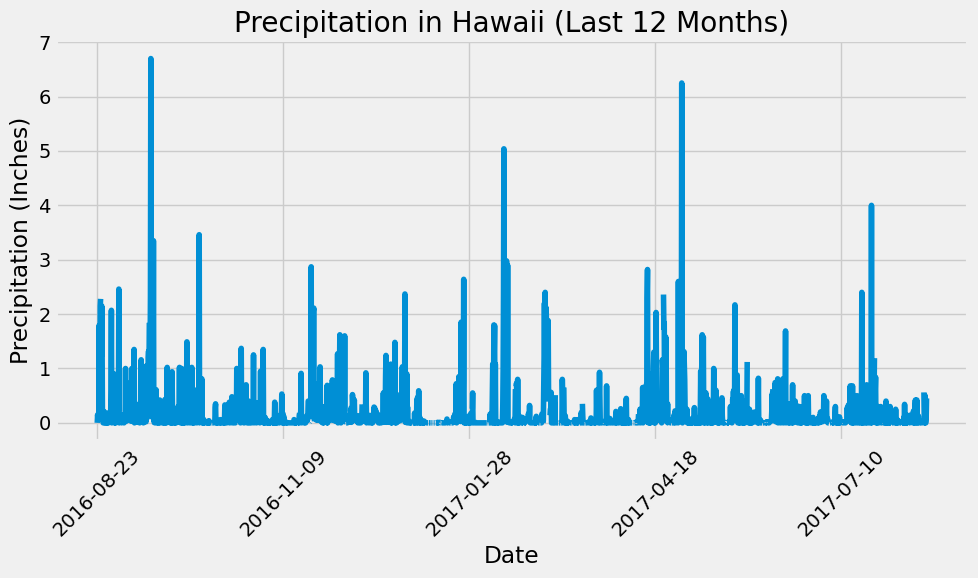

In [9]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# Calculate the date one year from the last date in data set.
most_recent_date = session.query(func.max(Measurement.date)).scalar()
most_recent_date
# Perform a query to retrieve the data and precipitation scores
prcp_df = pd.read_sql(session.query(Measurement.date, Measurement.prcp).
                      filter(Measurement.date >= func.date("2017-08-23", '-12 months')).
                      order_by(Measurement.date).
                      statement, session.bind)
prcp_df["prcp"] = pd.to_numeric(prcp_df["prcp"], errors="coerce")
# Sort the dataframe by date
prcp_df.set_index("date", inplace=True)

# Use Pandas Plotting with Matplotlib to plot the data
prcp_df.plot(y="prcp", figsize=(10,6), legend=False)
plt.xlabel("Date")
plt.ylabel("Precipitation (Inches)")
plt.title("Precipitation in Hawaii (Last 12 Months)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show

In [10]:
# Use Pandas to calculate the summary statistics for the precipitation data
summary_stats = prcp_df["prcp"].describe()
print(summary_stats)

count    2021.000000
mean        0.177279
std         0.461190
min         0.000000
25%         0.000000
50%         0.020000
75%         0.130000
max         6.700000
Name: prcp, dtype: float64


# Exploratory Station Analysis

In [11]:
# Design a query to calculate the total number of stations in the dataset
total_stations = session.query(func.count(Station.station)).scalar()
print(f"Total number of stations: {total_stations}")

Total number of stations: 9


In [12]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.

active_stations = session.query(Station.station, func.count
                               (Measurement.station).label("observation_count")).\
    join(Measurement, Station.station == Measurement.station).\
    group_by(Station.station).\
    order_by(func.count(Measurement.station).desc()).all()
active_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [13]:
# which station id has the greatest number of observations?
most_active_station = active_stations[0]
most_active_station

('USC00519281', 2772)

In [14]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.

# Get the station ID with the greatest number of observations
most_active_station_id = active_stations[0].station

# Query to calculate lowest, highest, and average temperatures for the most-active station
temperature_stats = session.query(func.min(Measurement.tobs).label("lowest_temperature"),
                                  func.max(Measurement.tobs).label("highest_temperature"),
                                  func.avg(Measurement.tobs).label("average_temperature")).\
    filter(Measurement.station == most_active_station_id).all()
temperature_stats

(54.0, 85.0, 71.66378066378067)

<function matplotlib.pyplot.show(close=None, block=None)>

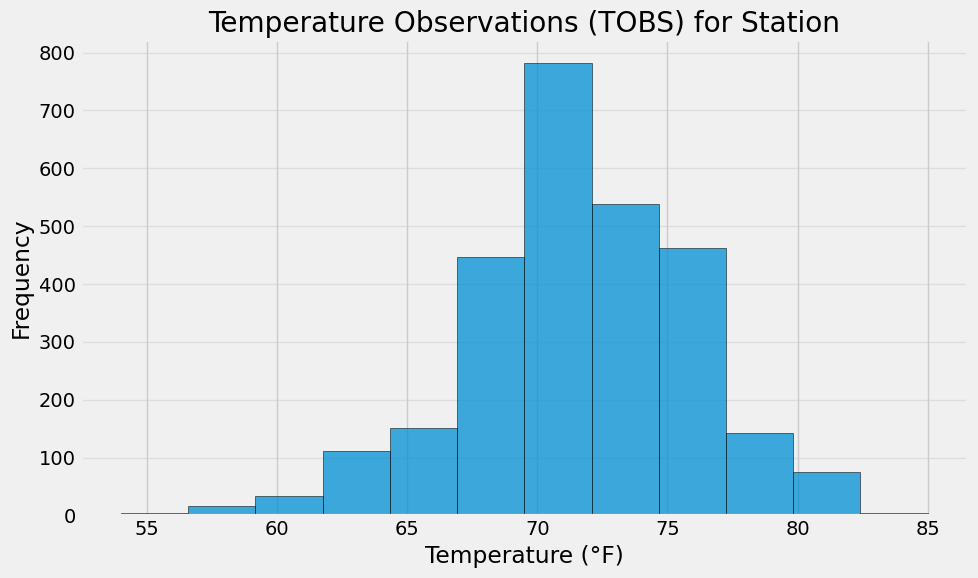

In [15]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

# Calculate the date 12 months ago from the last date in the dataset
last_date = session.query(Measurement.date).\
    filter(Measurement.station == most_active_station_id).\
    order_by(Measurement.date.desc()).first()[0]

one_year_ago = dt.datetime.strptime(last_date, '2017-08-18') - dt.timedelta(days=365)

tobs_data = session.query(Measurement.date, Measurement.tobs).\
    filter(Measurement.station == most_active_station_id).\
    filter(Measurement.date >= one_year_ago).\
    order_by(Measurement.date).all()
# DataFrame from the query results
tobs_df = pd.DataFrame(tobs_data, columns=['Date', 'TOBS'])

# Plot the TOBS data as a histogram
plt.figure(figsize=(10,6))
plt.hist(tobs_df["TOBS"], bins=12, alpha=.75, edgecolor="black")
plt.xlabel("Temperature (°F)")
plt.ylabel("Frequency")
plt.title(f"Temperature Observations (TOBS) for Station")
plt.grid(axis="y", alpha=0.5)
plt.tight_layout()
plt.show

# Close Session

In [16]:
# Close Session
session.close()

# Part 2

In [17]:
from flask import Flask, jsonify

In [18]:
app = Flask("__SaveGingers__")

In [19]:
# Define Homepage
@app.route('/')
def homepage():
    return (
        "Howdy and Welcome to Climate Analysis API<br><br>"
        "Available Routes:<br/>"
        "/api/v1.0/precipitation - Precipitation data for the previous year 8/16-8/17<br/>"
        "/api/v1.0/stations - List of weather stations<br/>"
        "/api/v1.0/tobs - Temperature observations (TOBS) for the previous year<br/>"
        "/api/v1.0/start_date - Temperature stats from a start date<br/>"
        "/api/v1.0/start_date/end_date - Temperature stats between start and end dates"
    )

In [20]:
# Define Precipitation
@app.route('/api/v1.0/precipitation')
def precipitation():
    prcp_df = pd.DataFrame(prcp_df)
    prcp_dict = prcp_df.set_index('date')['prcp'].to_dict()
    prcp_dict
    return jsonify(prcp_dict)
if "__SaveGingers__" == '__main__':
    app.run(debug=True)

In [21]:
# Define Stations
@app.route('/api/v1.0/stations')
def stations():
    connect = engine.connect()
    query = connect.execute(Station.select())
    stationx_list = [dict(row) for row in query]
    stationx_list
    return jsonify 
if "__SaveGingers__ "== '__main__':
    app.run(debug=True)

In [22]:
# Define TOBS
@app.route('/api/v1.0/tobs')
def tobs():
    active_stations = session.query(Station.station, func.count
                               (Measurement.station).label("observation_count")).\
    join(Measurement, Station.station == Measurement.station).\
    group_by(Station.station).\
    order_by(func.count(Measurement.station).desc()).all()
    active_stations
    
    # Calculate the date 12 months ago from the last date in the dataset
    last_date = session.query(Measurement.date).\
        filter(Measurement.station == most_active_station_id).\
        order_by(Measurement.date.desc()).first()[0]

    one_year_ago = dt.datetime.strptime(last_date, '2017-08-18') - dt.timedelta(days=365)
    
    # Query temperature observations for the most-active station for the last year
    tobs_data = session.query(Measurement.date, Measurement.tobs).\
    filter(Measurement.station == most_active_station_id).\
    filter(Measurement.date >= one_year_ago).\
    order_by(Measurement.date).all()
    
    # DataFrame from the query results
    tobs_df = pd.DataFrame(tobs_data, columns=['Date', 'TOBS'])
    tobs_df
    
    return jsonify(tobs_df)
if "__SaveGingers" == '__main__':
    app.run(debug=True)

In [24]:
# Define Temperature Start date MIN MAX and AVG
@app.route('/api/v1.0/<start_date>')
def temperature_stats_start(start_date):
        temperature_stats = engine.execute(
        f"SELECT MIN(tobs) AS TMIN, AVG(tobs) AS TAVG, MAX(tobs) AS TMAX FROM measurement WHERE date >= '2016-08-18'"
        ).fetchone()
        #- Create Dictionary
        temperature_stats_dict = {
        'TMIN': temperature_stats['TMIN'],
        'TAVG': temperature_stats['TAVG'],
        'TMAX': temperature_stats['TMAX']
        }
        return jsonify(temperature_stats_dict)

    
# Define Temperature Start through End Date MIN MAX and AVG
@app.route('/api/v1.0/<start_date>/<end_date>')
def temperature_stats_start_end(start_date, end_date):
        temperature_stats = engine.execute(
        f"SELECT MIN(tobs) AS TMIN, AVG(tobs) AS TAVG, MAX(tobs) AS TMAX FROM measurement WHERE date BETWEEN '2016-08-18' AND '2017-08-18'"
        ).fetchone()
        
        #Create Dictionary
        temperature_stats_dict = {
            'TMIN': temperature_stats['TMIN'],
            'TAVG': temperature_stats['TAVG'],
            'TMAX': temperature_stats['TMAX']
        }
        
        return jsonify(temperature_stats_dict)
if "__SaveGingers__" == '__main__':
    app.run(debug=True)